# Actividad para evaluación de 3er parcial

Dado lo aprendido a lo largo del semestre durante la materia (python, grafos, interpretación y análisis de conectividad)

El 3er parcial se evaluará a través de la actividad:
__Aplicación y análisis a un dataset__

__Dataset a utilizar__: https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel

# Rúbrica para evaluación de 3er parcial

Se evaluará:
- Que el script no contenga errores
- Que los resultados del script sean reproducibles, ie que puedan ser reproducibles en cualquier computadora
- El orden del código
- La lógica del código
- La *inferencia* empleada para los parámetros utilizados, tales como thresholds para filtrado de matriz, elección de thresholds para selección de alguna banda específica (alfa, beta, delta, etc.) 
- Los métodos utilizados, ie, si para construir la matriz de conectividad se utilizó coherencia espectral, PLV o correlación, que haya una razón de ello
- Los resultados mostrados, tales como mapas de calor, grafos 2D, grafos 3D, el mostrar comunidades, hubs, nodos proporcionales al grado, filtrado de matriz de
- Conclusión del análisis, ie, al finalizar el análisis dar una conclusión que resuma los resultados encontrados con una interpretación de los mismos
- Que el análisis haya sido aplicado a cada uno de los ensayos/archivos del dataset

In [52]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sp
from scipy.io import loadmat
import mne
import glob
import os

In [53]:
ensay03_excel= r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx"
ensayo04_excel= r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx"
coordenadas=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\MI_coordinates.csv"

##Los excel van a ser diccionarios
ensayo3_d= pd.read_excel(ensay03_excel, sheet_name=None, index_col=0) ##agarrar los mismos indíces del excel
ensayo04_d= pd.read_excel(ensayo04_excel, sheet_name=None, index_col=0)

In [54]:
ensayos3_dfs=[]

for sujeto in ensayo3_d.keys():
    ensayos3_dfs.append(ensayo3_d[sujeto])


In [55]:
##Filtrado de matrices, apilación
umbral= 0.62
porcentaje= 0.6 ## 
stack=np.stack([df.values for df in ensayos3_dfs]) ##esto solo apila
above= stack> umbral
N= len(ensayos3_dfs)
contar= above.sum(axis=0) ##aquí estamos contando cuantos valores superan el umbral en cada celda

min_requerido= int(np.ceil(porcentaje*N)) 
resultado_boleano= contar>= min_requerido

result_df= pd.DataFrame(resultado_boleano, index=ensayos3_dfs[0].index, columns= ensayos3_dfs[0].columns).astype(int)
print(result_df)
#Con esto bastará con quedarnos con las celdas de abova que cumplan con el min requerido, para así tener el número de sujeto que superan el umbral. 
#esto dice: cada celca tendrá un 1 si al menos 60% de los sujetos cumplierón con el umbral, si la celca es 0, significa que menos del 60% de los sujetos
#cumplierón con el umbral


      Fc5.  Fc3.  Fc1.  Fcz.  Fc2.  Fc4.  Fc6.  C5..  C3..  C1..  ...  P8..  \
Fc5.     0     1     0     0     0     0     0     1     1     0  ...     0   
Fc3.     1     0     1     1     0     0     0     1     1     1  ...     0   
Fc1.     0     1     0     1     1     0     0     0     1     1  ...     0   
Fcz.     0     1     1     0     1     1     0     0     1     1  ...     0   
Fc2.     0     0     1     1     0     1     0     0     0     1  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
Po8.     0     0     0     0     0     0     0     0     0     0  ...     1   
O1..     0     0     0     0     0     0     0     0     0     0  ...     0   
Oz..     0     0     0     0     0     0     0     0     0     0  ...     0   
O2..     0     0     0     0     0     0     0     0     0     0  ...     0   
Iz..     0     0     0     0     0     0     0     0     0     0  ...     0   

      Po7.  Po3.  Poz.  Po4.  Po8.  O1..  Oz..  O2.

In [ ]:
print("Heatmap apilado con un umbral arbitrario al 60%")
plt.figure(figsize=(5,3))

sns.heatmap(result_df)

ValueError: Input could not be cast to an at-least-1D NumPy array

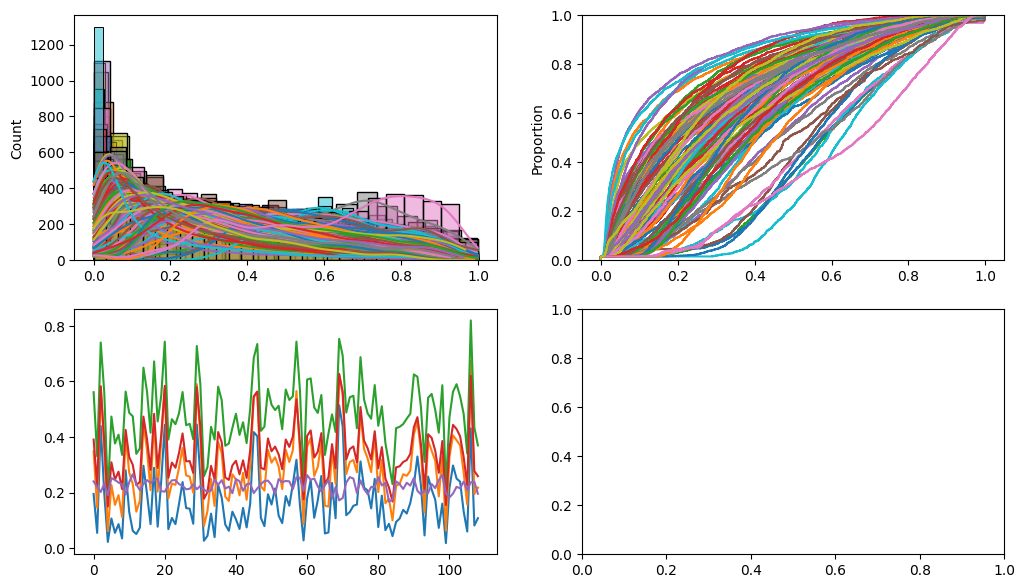

In [56]:
##Calcular estadísticos para decidir umbrales:
t25, t50, t75, promedio, varianza= [],[],[],[],[]
mu_sigm=[]
fig, axes= plt.subplots(2,2, figsize=(12,7))
for sujeto in ensayos3_dfs:
    data=sujeto.stack().values
    t25.append(np.percentile(data, 25))
    t50.append(np.percentile(data,50))
    t75.append(np.percentile(data,75))
    promedio.append(np.mean(data))
    varianza.append(np.std(data))
    mu_sigm.append(promedio+varianza)
    #plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True) ##kde es para la distribución, stack es para aplanar
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1]) ##distribución acumulada
axes[1][0].plot(t25, label="percentile 25")
axes[1][0].plot(t50, label="percentile 25")
axes[1][0].plot(t75, label="percentile 25")
axes[1][0].plot(promedio, label="percentile 25")
axes[1][0].plot(varianza, label="percentile 25")
axes[1][0].plot(mu_sigm, label="percentile 25")

    




In [46]:
data= pd.DataFrame(columns=["t25", "t50", "t75", "promedio", "varianza"], index=["min", "max", "media", "percentil30","mediana"])
columnas=[t25, t50, t75, promedio, varianza]
minimos=[]
maximos=[]
media=[]
perc30=[]
mediana=[]
cosa=[]
for lista in columnas:
    a=min(lista)
    minimos.append(a)
    b=max(lista)
    maximos.append(b)
    medias= np.mean(lista)
    media.append(medias)
    perc=np.percentile(lista, 30)
    perc30.append(perc)
    m=np.median(lista)
    mediana.append(m)

data.loc["min"]=minimos
data.loc["max"]=maximos
data.loc["media"]=media
data.loc["percentil30"]=perc30
data.loc["mediana"]=mediana
data

,t25,t50,t75,promedio,varianza
min,0.018413,0.06175,0.196867,0.149821,0.16782
max,0.514472,0.674805,0.819681,0.626848,0.266529
media,0.166961,0.295352,0.489628,0.345504,0.224412
percentil30,0.089118,0.220086,0.432409,0.28858,0.212498
mediana,0.144574,0.273808,0.484181,0.3277,0.227821
